In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from xgboost import XGBClassifier

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ojasv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_excel(r"C:\Users\ojasv\smartedurecommendor\Student Details (Responses).xlsx")
df.head()


,Student Name,SRN,Program,YEAR OF STUDY,Age,Sex,Education [Mother's Education],Education [Father's Education],"Mother""s Occupation",Father's Occupation,...,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,SEM-1,SEM-2,SEM-3,SEM-4,SEM-5
0,Kalluru Harsha Vardhan Reddy,R22DE061,MSC,I,23,Male,Schooling,Schooling,Home Maker,Own Business,...,6,Overweight,126/83,77,4200,7.8,8.2,9.0,6.6,8.0
1,Neha Valmiki,R22DG034,MSC,II,22,Female,Schooling,Schooling,Home Maker,Public Service,...,8,Normal,125/80,75,10000,6.9,7.5,8.0,0.0,0.0
2,kommandi Bhavan,R22DG070,MSC,III,24,Male,Schooling,Graduate,Home Maker,Own Business,...,8,Normal,125/80,75,10000,6.0,7.0,8.0,NaN,NaN
3,Kalluru Harsha Vardhan Reddy,R22DE061,MCA,III,23,Male,Schooling,12th class,Home Maker,Own Business,...,8,Obese,140/90,85,3000,6.0,7.0,7.8,8.2,NaN
4,Kancham Reddy Akhila,R22DE062,MCA,III,23,Female,Graduate,Graduate,Private Sector,Own Business,...,8,Obese,140/90,85,3000,9.0,9.2,9.4,9.0,NaN


In [3]:
for col in df.columns:
    if df[col].dtype == 'object':
        if not df[col].mode().empty:
            df[col] = df[col].fillna(df[col].mode()[0])
    else:
        if df[col].notna().any():
            df[col] = df[col].fillna(df[col].mean())



In [4]:
# Normalize numeric features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])


In [5]:
# Averaging semester scores
df['Overall Performance'] = df[['SEM-1', 'SEM-2', 'SEM-3', 'SEM-4', 'SEM-5']].mean(axis=1)


In [6]:
def categorize(score):
    if score >= 0.75:
        return 2  # Strong
    elif score >= 0.5:
        return 1  # Average
    else:
        return 0  # Weak

df['Performance Category'] = df['Overall Performance'].apply(categorize)


In [7]:
!pip install xgboost


In [8]:
# Convert all column names to strings
X = df.drop('Performance Category', axis=1)
y = df['Performance Category']
X.columns = X.columns.astype(str)


In [9]:
import re

# Replace everything except letters, numbers, and underscores
X.columns = [re.sub(r'[^\w]', '_', col) for col in X.columns]


In [10]:
print(X.columns.tolist())


['Student_Name', 'SRN', 'Program', 'YEAR_OF_STUDY', 'Age', 'Sex', 'Education__Mother_s_Education_', 'Education__Father_s_Education_', 'Mother_s_Occupation', 'Father_s_Occupation', 'Number_of_Siblings', 'Parents_Relationship_Status____________', 'Medium_of_study', 'Marks_scored_during_previous_study_PU_12th_UG_etc__', 'Accommodation_type__', 'Transportation_to_the_university___1__Bus__2__Private_car_taxi__3__bicycle__4__Other_', 'Daily_Travel_time__in_min__to_and_fro______________________________________', 'Weekly_study_time__________________', 'Participation__Reading_frequency_Scientific_Non_scientific_journals__research_articles__', 'Participation__Taking_notes_in_classes___', 'Participation__Listening_in_classes__', 'Participation__Participation_in_Discussion_about_taught_topics_in_class_', 'collaboration_level', 'Preparation_for_IA_and_SEE_exams_', 'How_do_you_prepare_for_examinations_', 'How_often_do_you_attend_classes_', 'If_you_miss_classes__what_is_the_primary_reason_', 'Extracu

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
from xgboost import XGBClassifier

model = XGBClassifier(eval_metric='mlogloss')
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [13]:
y_pred = model.predict(X_test)

In [14]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Confusion Matrix:
 [[ 9  0  0]
 [ 0 92  0]
 [ 0  0 10]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        92
           2       1.00      1.00      1.00        10

    accuracy                           1.00       111
   macro avg       1.00      1.00      1.00       111
weighted avg       1.00      1.00      1.00       111



In [15]:
joblib.dump(model, "edu_model.pkl")


['edu_model.pkl']

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

study_materials = [
    "Basic concepts of Data Structures and Algorithms",
    "Intermediate Python practice problems and quizzes",
    "Advanced Machine Learning techniques and research papers",
    "Beginner guide to Time Management and Focus",
    "High-level readings on Data Science Trends",
    "Intro to DBMS with examples",
    "Practice quiz on Operating Systems",
    "Research paper on Deep Learning in Education"
]

queries = {
    0: "beginner topics and concepts",   # Weak
    1: "practice quiz and tests",        # Average
    2: "advanced readings and research"  # Strong
}

def recommend_materials(category, top_n=3):
    query = queries.get(category, "beginner topics")
    docs = [query] + study_materials
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(docs)
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
    top_indices = cosine_sim.argsort()[-top_n:][::-1]
    return [study_materials[i] for i in top_indices]


In [17]:
student_pred = model.predict([X_test.iloc[0]])[0]
recs = recommend_materials(student_pred)

print("📘 Recommended Materials:")
for rec in recs:
    print("•", rec)


📘 Recommended Materials:
• Beginner guide to Time Management and Focus
• Basic concepts of Data Structures and Algorithms
• Intermediate Python practice problems and quizzes


In [18]:
from sklearn.preprocessing import LabelEncoder

def encode_dataframe(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    return df

X = encode_dataframe(X)


In [19]:
predictions = model.predict(X)


In [20]:
import joblib

# After model training
model.fit(X_train, y_train)

# Save model
joblib.dump(model, "edu_model.pkl")

# VERY IMPORTANT: Save the exact column order used in training
joblib.dump(X_train.columns.tolist(), "model_features.pkl")


['model_features.pkl']

In [21]:
# Step 1: Train the model
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)

# Step 2: Save model the correct way
import joblib
joblib.dump(model, "edu_model.pkl")  # ✅ This saves the full scikit-style model

# Step 3: Also save training feature names (optional but helpful for UI)
joblib.dump(X_train.columns.tolist(), "model_features.pkl")  # optional


['model_features.pkl']

In [22]:
import joblib
joblib.dump(model, "edu_model.pkl")

['edu_model.pkl']

In [23]:
from xgboost import XGBClassifier
import joblib

# Assuming model is already trained
model = XGBClassifier()
model.fit(X_train, y_train)

# ✅ Correct way to save model (this will work in Streamlit)
joblib.dump(model, "edu_model.pkl")   # DO NOT use model.save_model()


['edu_model.pkl']

In [24]:
# Sanity test before upload
model_loaded = joblib.load("edu_model.pkl")
print(model_loaded.predict(X_train[:5]))  # If this works, Streamlit will too


[2 1 1 1 1]


In [25]:
print(X_train.columns.tolist())


['Student_Name', 'SRN', 'Program', 'YEAR_OF_STUDY', 'Age', 'Sex', 'Education__Mother_s_Education_', 'Education__Father_s_Education_', 'Mother_s_Occupation', 'Father_s_Occupation', 'Number_of_Siblings', 'Parents_Relationship_Status____________', 'Medium_of_study', 'Marks_scored_during_previous_study_PU_12th_UG_etc__', 'Accommodation_type__', 'Transportation_to_the_university___1__Bus__2__Private_car_taxi__3__bicycle__4__Other_', 'Daily_Travel_time__in_min__to_and_fro______________________________________', 'Weekly_study_time__________________', 'Participation__Reading_frequency_Scientific_Non_scientific_journals__research_articles__', 'Participation__Taking_notes_in_classes___', 'Participation__Listening_in_classes__', 'Participation__Participation_in_Discussion_about_taught_topics_in_class_', 'collaboration_level', 'Preparation_for_IA_and_SEE_exams_', 'How_do_you_prepare_for_examinations_', 'How_often_do_you_attend_classes_', 'If_you_miss_classes__what_is_the_primary_reason_', 'Extracu

Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 52 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   Student Name                                                                              553 non-null    object 
 1   SRN                                                                                       553 non-null    object 
 2   Program                                                                                   553 non-null    object 
 3   YEAR OF STUDY                                                                             553 non-null    object 
 4   Age                                                                                       553 non-null    int64  
 5   Sex                                        

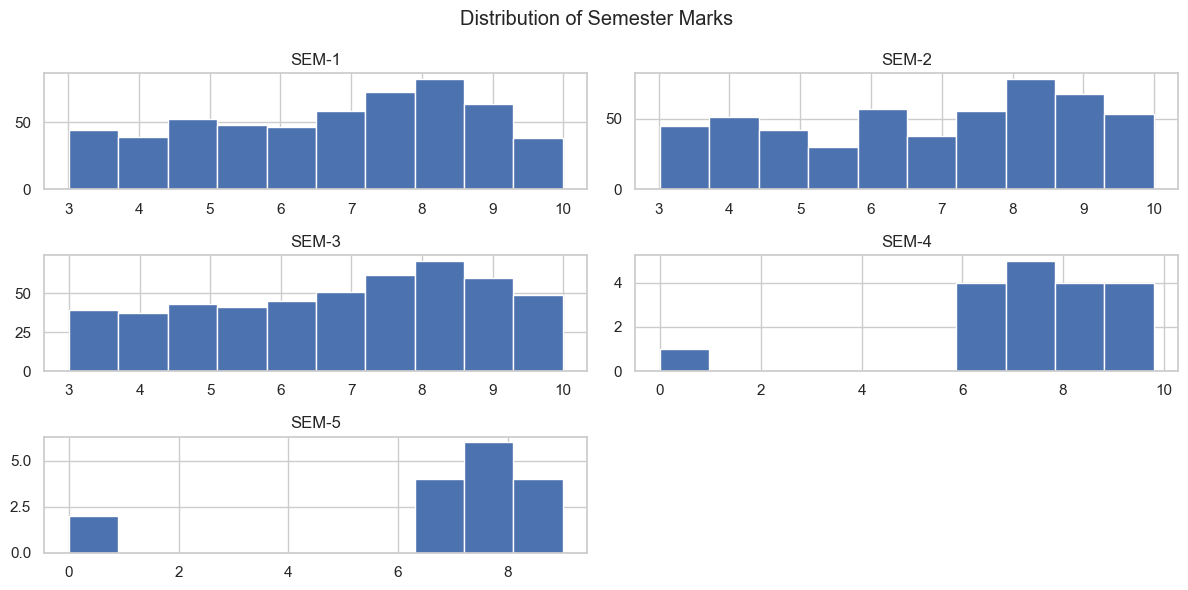

ValueError: hist method requires numerical or datetime columns, nothing to plot.

In [33]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set aesthetic style
sns.set(style="whitegrid")

# Load the dataset
df = pd.read_excel(r"C:\Users\ojasv\smartedurecommendor\Student Details (Responses).xlsx")



# Show basic info
print("Data Summary:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# -------------------------
# UNIVARIATE ANALYSIS
# -------------------------

# 1. Histogram: Semester Marks
sem_cols = ['SEM-1', 'SEM-2', 'SEM-3', 'SEM-4', 'SEM-5']
df[sem_cols].hist(figsize=(12, 6), bins=10)
plt.suptitle("Distribution of Semester Marks")
plt.tight_layout()
plt.show()

# 2. Histogram: Study Time and Sleep
df[['Weekly study time:                 ', 'average sleep duration']].hist(figsize=(10, 4), bins=10)
plt.suptitle("Study Time and Sleep Duration Distribution")
plt.tight_layout()
plt.show()

# 3. Countplot: Categorical Features
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.countplot(x='Sex', data=df)
plt.title("Gender Distribution")

plt.subplot(1, 3, 2)
sns.countplot(x='Program', data=df)
plt.title("Program Distribution")
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.countplot(x='Stress_Level', data=df)
plt.title("Stress Level Distribution")
plt.tight_layout()
plt.show()

# -------------------------
# BIVARIATE ANALYSIS
# -------------------------

# 1. Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# 2. Study Time vs Average Marks
df['Average_Marks'] = df[sem_cols].mean(axis=1)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Weekly study time:                 ', y='Average_Marks', data=df, hue='Program')
plt.title("Weekly Study Time vs Average Marks")
plt.show()

# 3. Sleep vs Average Marks
plt.figure(figsize=(8, 5))
sns.scatterplot(x='average sleep duration', y='Average_Marks', data=df)
plt.title("Sleep Duration vs Average Marks")
plt.show()

# 4. Boxplot: Stress vs Average Marks
plt.figure(figsize=(8, 5))
sns.boxplot(x='Stress_Level', y='Average_Marks', data=df)
plt.title("Stress Level vs Academic Performance")
plt.show()

# 5. Recent Academic Trend: SEM_4 vs SEM_5
plt.figure(figsize=(8, 5))
sns.scatterplot(x='SEM-4', y='SEM-5', data=df)
plt.title("Performance Trend: SEM-4 vs SEM-5")
plt.show()


In [32]:
print("Actual Columns:", df.columns.tolist())


Actual Columns: ['Student Name', 'SRN', 'Program', 'YEAR OF STUDY', 'Age', 'Sex', "Education [Mother's Education]", "Education [Father's Education]", 'Mother"s Occupation', "Father's Occupation", 'Number of Siblings', 'Parents Relationship Status:           ', 'Medium of study', 'Marks scored during previous study(PU/12th/UG etc.)', 'Accommodation type: ', 'Transportation to the university: (1: Bus, 2: Private car/taxi, 3: bicycle, 4: Other)', 'Daily Travel time (in min)(to and fro)                                     ', 'Weekly study time:                 ', 'Participation [Reading frequency(Scientific/Non-scientific journals, research articles)]', 'Participation [Taking notes in classes: ]', 'Participation [Listening in classes:]', 'Participation [Participation in Discussion about taught topics in class]', 'collaboration level', 'Preparation for IA and SEE exams:', 'How do you prepare for examinations?', 'How often do you attend classes?', 'If you miss classes, what is the primary re